# Homework 3: ***Probabilistic Programming*** and ***Probabilistic Graphical Models***

Probabilistic Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/emaballarin/probml-units/blob/main/homework-2023/03_prob_prog_pgms_HW.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Before starting, a read of [the recap notebook on ***Probabilistic Graphical Models***](https://github.com/emaballarin/probml-units/blob/main/notebooks/04_graphical_models.ipynb) is strongly recommended!  
Notebooks [\#1](https://github.com/emaballarin/probml-units/blob/main/notebooks/03a_probabilistic_programming.ipynb) and [\#2](https://github.com/emaballarin/probml-units/blob/main/notebooks/03b_probabilistic_programming.ipynb) about ***Probabilistic Programming*** and inference in `Pyro` may also be useful for the practical part.

### Exercise 1 (theory: *Bayesian Networks*)

1. Draw the *Bayesian Network* representation of the joint distribution:

$$P(A,B,C,D,E,F,G)=P(A)P(B|A)P(F|B)P(C|A)P(D|B)P(E|D,F)P(G).$$

2. Indicate whether the following statements on (conditional) independence are `True` or `False` in such joint distribution, and motivate your answer.

    (a.) ${~}$ ${~}$ $A\perp \!\!\! \perp D$  
    (b.) ${~}$ ${~}$ $F\perp \!\!\! \perp D$  
    (c.) ${~}$ ${~}$ $A\perp \!\!\! \perp B\ |\ C$  
    (d.) ${~}$ ${~}$ $A\perp \!\!\! \perp D\ |\ B$  
    (e.) ${~}$ ${~}$ $D\perp \!\!\! \perp F\ |\ E$  
    (f.) ${~}$ ${~}$ $B\perp \!\!\! \perp F\ |\ E$  
    (g.) ${~}$ ${~}$ $A\perp \!\!\! \perp D\ |\ \{B, F\}$  

### Exercise 2 (practicum: *Probabilistic Graphical Models* in `Pyro`)

1. Write the generative model represented by the following directed graph
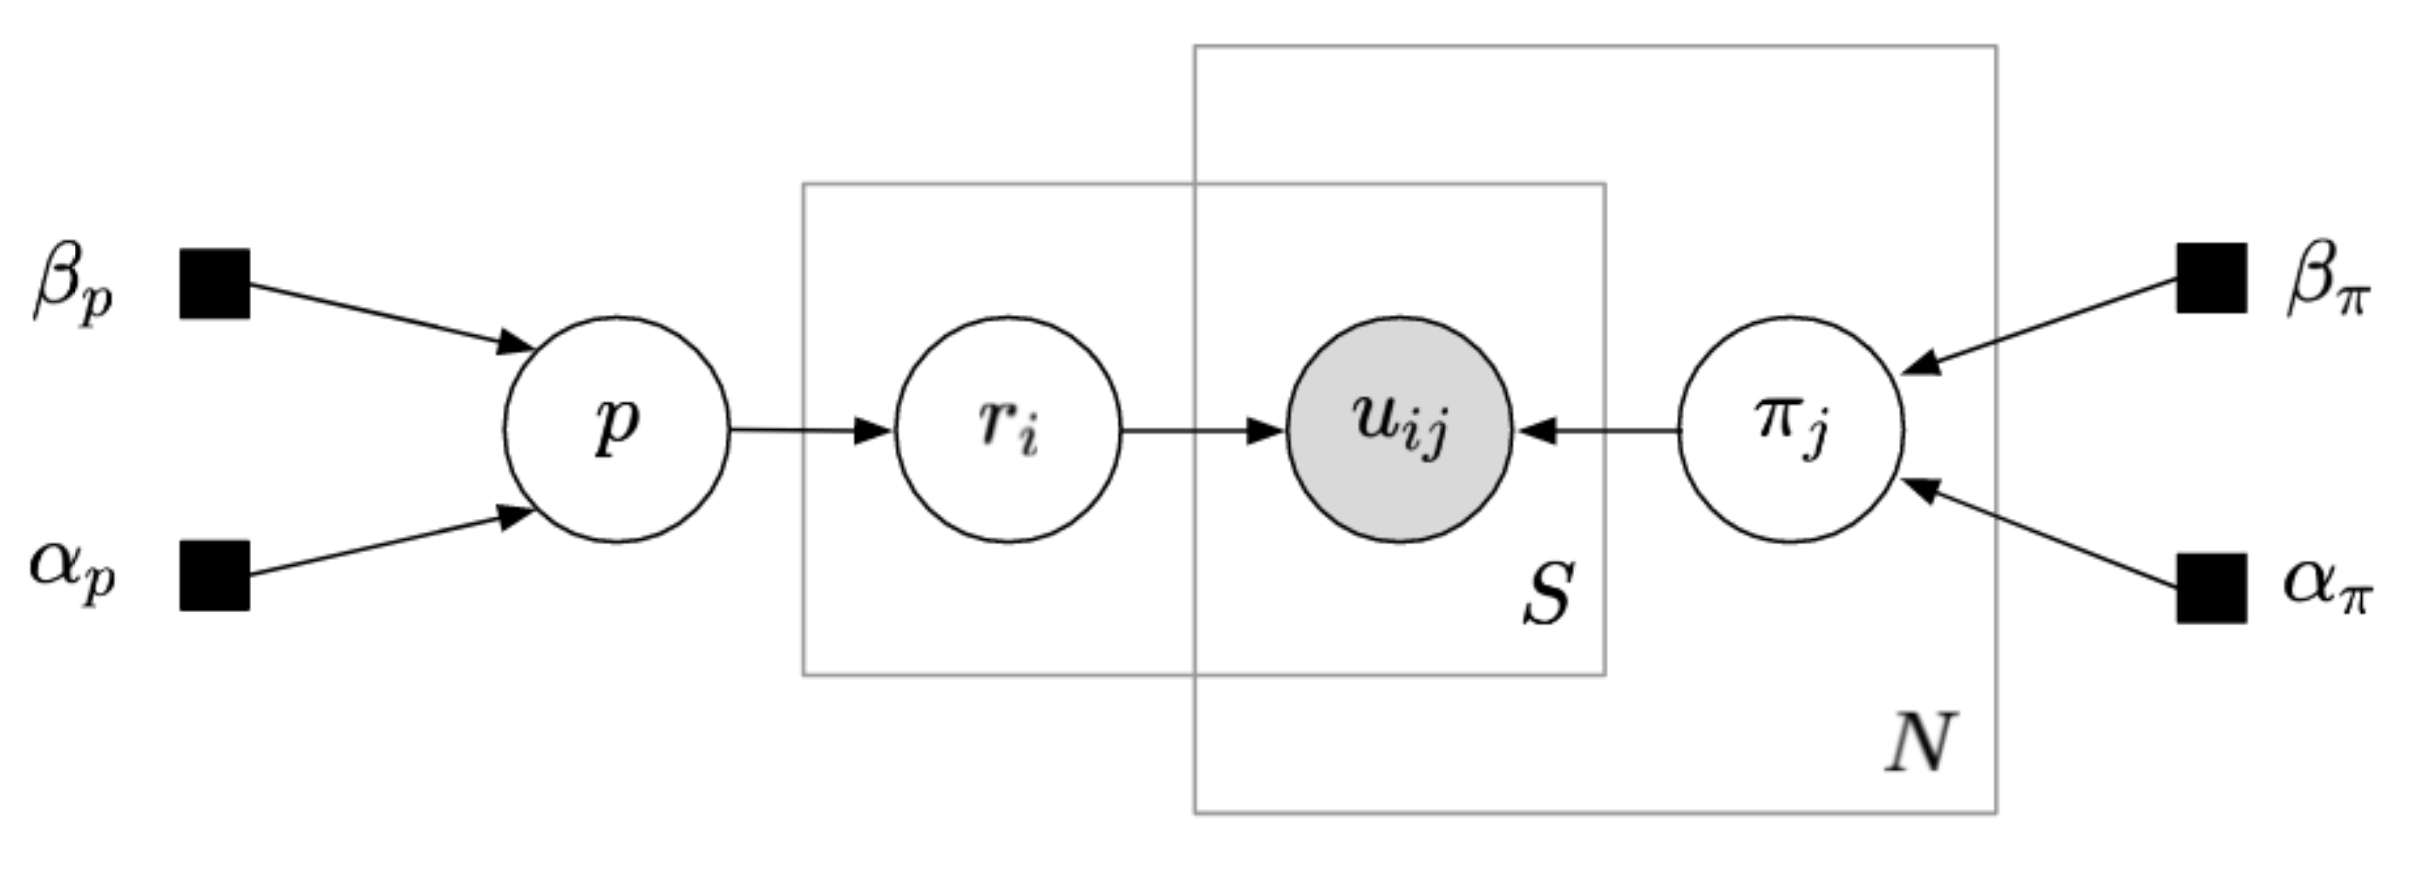
where:  
    i.  )  $p$ and $\pi_j$ are sampled from Beta distributions;  
    ii. )  $r_i$ is sampled from a Bernoulli distribution;  
    iii.)  $u_{ij}$ is sampled from a Bernoulli distribution with parameter $r_i (1 - \pi_j) + (1 - r_i)\pi_j$.  

2. Implement the same generative model in `Pyro`.  
Set the hyperparameters to $\alpha_p=1,\ \ \beta_p=1,\ \ \alpha_\pi=1,\ \ \beta_\pi=5$ and evaluate your model on synthetic observations obtained as `data = pyro.distributions.Bernoulli(0.6).sample((12,6))`.  
Remember to use the *plate notation* adequately and to condition on observed data!  
If you need to jointly *plate* *w.r.t.* different variables, you can use `pyro.plate` context managers as follows:

    ```python
    plate_1 = pyro.plate(...)
    plate_2 = pyro.plate(...)

    with plate_1:
        # do something while plating on plate_1 only
    
    with plate_2:
        # do something while plating on plate_2 only

    with plate_1, plate_2:
        # do something while jointly-plating

In [2]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

In [9]:
data = dist.Bernoulli(0.6).sample((12,6))
data

tensor([[0., 0., 1., 0., 1., 1.],
        [1., 1., 0., 1., 1., 0.],
        [1., 0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 1., 0.],
        [0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 1.],
        [1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0.],
        [1., 1., 0., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1.]])

In [10]:
# hyperparameters
alpha_p: float = 1.0
beta_p: float = 1.0

alpha_pi: float = 1.0
beta_pi: float = 5.0

def model(data):
    N: int = len(data) # We assume that we have N = 12 and S = 6 from example above
    S: int = len(data[0])
 
    # "Global" variables: 
    p = pyro.sample("p", dist.Beta(alpha_p, beta_p))

    # Define the two plates
    plate_1 = pyro.plate("S plate", S, dim=-1)
    plate_2 = pyro.plate("N plate", N, dim=-2)

    with plate_1:
        r = pyro.sample("r", dist.Bernoulli(p))
    with plate_2:
        pi = pyro.sample("pi", dist.Beta(alpha_pi, beta_pi))
    
    with plate_1, plate_2:
            u = pyro.sample("u", dist.Bernoulli(r*(1 - pi) + (1 - r) * pi), obs = data)

    print(f"p = {p}\nr = {r}\npi = {pi}\nu = {u}")
    return(p)

In [19]:
model(data)

p = 0.5750460624694824
r = tensor([0., 0., 1., 1., 1., 0.])
pi = tensor([[0.2672],
        [0.3332],
        [0.2030],
        [0.1819],
        [0.0067],
        [0.0016],
        [0.3997],
        [0.1389],
        [0.3115],
        [0.0216],
        [0.0562],
        [0.1460]])
u = tensor([[0., 0., 1., 0., 1., 1.],
        [1., 1., 0., 1., 1., 0.],
        [1., 0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 1., 0.],
        [0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 1.],
        [1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0.],
        [1., 1., 0., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 1.]])


tensor(0.5750)

### Exercise 3 (practicum: *Gaussian Process Classification* in `Pyro`)

Consider an instance of the *Half Moons* dataset, a *toy* dataset for classification featuring two interleaving noisy half-annuli. For the sake of simplicity, it has been already be generated, plotted, and converted to `PyTorch` tensors for you:

In [32]:
import numpy as np
import torch as th
import pyro

import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import seaborn as sns

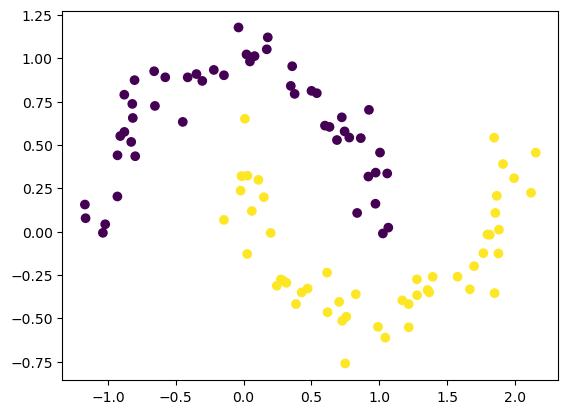

In [33]:
x, y = make_moons(n_samples=100, shuffle=True, noise=0.1, random_state=1)
_ = plt.scatter(x[:, 0], x[:, 1], c=y)

In [34]:
x, y = th.from_numpy(x).float(), th.from_numpy(y).float()

Consider the following generative model:

$$
\begin{align*}
    (y_n \ |\  p_n) &\sim \mathrm{Bern}(p_n) \quad \text{for } n=1,\ldots,N\\
    (\mathrm{logit}(\boldsymbol{p})\ |\ \mu,\sigma,l) &\sim \mathcal{GP}(\mu, K_{\sigma,\  l}(x_n))\\
    \mu &\sim \mathcal{N}(0,1)\\
    \sigma &\sim \mathrm{LogNormal}(0,1)\\
    l &\sim \mathrm{LogNormal}(0,1)
\end{align*}
$$

where we model:
- the binary response variable with a Bernoullian likelihood;
- the logit of the joint probability $\boldsymbol{p} = (p_1, \dots, p_n, \dots, p_N)$ with a Gaussian Process having
    - predictors $x_n$,
    - mean $\mu$: harvested from a standard normal distribution,
    - kernel matrix $K_{\sigma, l}$, parameterized by:
        - variance $\sigma$ and lengthscale $l$: : harvested from two *i.i.d.* standard log-normal distributions.

We want to solve this binary classification problem by means of *Hamiltonian Monte Carlo* inference: this requires a reparametrization of the multivariate Gaussian $\mathcal{GP}(\mu, K_{\sigma,\  l}(x_n))$ for the sake computational efficiency.  

Specifically, we will model logit probability as:

$$\mathrm{logit}(\boldsymbol{p}) = \mu \cdot \mathbf{1}_N + \eta \cdot L,$$

where:
- $L$ is the *Cholesky factor* of $K_{\sigma,\  l}$
- $\eta_n\sim\mathcal{N}(0,1)$.

This relationship is implemented by the `get_logits` function below:


In [35]:
def get_logits(x, mu, sigma, l, eta):
    kernel = gp.kernels.RBF(
        input_dim=2,
        variance=(sigma if isinstance(sigma, th.Tensor) else th.tensor(sigma)),
        lengthscale=(l if isinstance(l, th.Tensor) else th.tensor(l)),
    )
    K = kernel.forward(x, x) + th.eye(x.shape[0]) * 1e-4
    L = th.linalg.cholesky(K)
    return mu + th.mv(L, eta)

Write a pyro model `gp_classifier(x, y, logit_function)` that implements the reparametrized generative model, using `get_logits` function. Remember to `plate` on independent observations!

In [36]:
def gp_classifier(x, y, logit_function):
    N: int = len(y)

    # Generate hyperparameters mu, sigma, l only once
    mu = pyro.sample("mu", dist.Normal(0, 1))
    sigma = pyro.sample("sigma", dist.LogNormal(0,1))
    l = pyro.sample("l", dist.LogNormal(0, 1))

    # Create a plate for generating samples of eta independently of one another.
    # Recall that a plate is equivalent to a for loop, so in the end we have a vector eta.
    with pyro.plate("etas", N):
        eta = pyro.sample("eta", dist.Normal(0, 1))
    
    # Calcolate the logit (i.e. the log odds) for all the observations using the logit_function and hyper-parameters
    logit_p = logit_function(x, mu, sigma, l, eta)        
   
    # Define a plate for the observations using a Bernoulli RV and passing the logit probabiility.
    #   We use obs to condition on the observed data, as these are passed to the model.
    with pyro.plate("observations", N):
        obs = pyro.sample("y", dist.Bernoulli(logits=logit_p), obs = y)

By using `pyro.NUTS` on the `gp_classifier` model, we can infer the posterior distribution of its parameters via the *No U-Turn Sampler*, an effective *HMC* method.  Posterior samples can be extracted using the `.get_samples()` method.

In [37]:
nuts_kernel = NUTS(gp_classifier)
mcmc = MCMC(nuts_kernel, warmup_steps=50, num_samples=10)
posterior = mcmc.run(x=x, y=y, logit_function=get_logits)
mcmc.summary()

Sample: 100%|██████████| 60/60 [06:30,  6.50s/it, step size=1.29e-02, acc. prob=0.356]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]      1.20      0.21      1.26      0.72      1.39      5.03      1.47
    eta[1]      0.36      0.52      0.28     -0.27      1.38      5.43      0.90
    eta[2]     -1.39      0.44     -1.53     -1.74     -0.56      4.24      1.34
    eta[3]     -0.56      0.48     -0.40     -1.33      0.14      5.00      1.50
    eta[4]      0.96      0.29      0.92      0.52      1.30      8.63      0.99
    eta[5]     -1.31      0.21     -1.32     -1.61     -0.88     36.69      0.92
    eta[6]     -1.52      0.21     -1.55     -1.81     -1.18      6.04      0.90
    eta[7]     -1.03      0.38     -1.15     -1.56     -0.49      6.82      0.90
    eta[8]      0.81      0.45      0.66      0.44      1.70      4.90      1.23
    eta[9]      0.26      0.27      0.21     -0.17      0.76      5.61      0.91
   eta[10]      0.01      0.27     -0.03     -0.37      0.58      3.93      1.52
   eta[11]     -1.40      0

In [38]:
mcmc_samples = mcmc.get_samples()

The `posterior_predictive` function shown below outputs the prediction corresponding to the $i$-th sample from the posterior.

In [39]:
def posterior_predictive(samples, i, x, x_grid):
    x, x_grid = x.float(), x_grid.float()

    kernel = gp.kernels.RBF(
        input_dim=2, variance=samples["sigma"][i], lengthscale=samples["l"][i]
    )
    n_grid = x_grid.shape[0]

    y = get_logits(
        x, samples["mu"][i], samples["sigma"][i], samples["l"][i], samples["eta"][i]
    )

    with th.no_grad():
        gpr = gp.models.GPRegression(x, y, kernel=kernel)
        mean, cov = gpr(x_grid, full_cov=True)

        mean, cov = mean.float(), cov.float()

    yhat = dist.MultivariateNormal(mean, cov + th.eye(n_grid) * 100 * 1e-4).sample()
    return yhat.sigmoid().numpy()

The `plot_pyro_predictions` function below calls `posterior_predictive` to compute the average prediction on each input point and plots the posterior predictive mean function over a finite grid of points.

In [40]:
def scatterplot(x, y):
    colors = np.array(["0", "1"])
    sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=colors[y.int()])


def meshgrid(x, n, eps=0.1):
    x0, x1 = np.meshgrid(
        np.linspace(x[:, 0].min() - eps, x[:, 0].max() + eps, n),
        np.linspace(x[:, 1].min() - eps, x[:, 1].max() + eps, n),
    )
    x_grid = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    return x0, x1, x_grid


def plot_pyro_predictions(posterior_samples, x, y):
    n_samples = posterior_samples["sigma"].shape[0]
    x0, x1, x_grid = meshgrid(x, 30)
    x_grid = th.from_numpy(x_grid)
    preds = np.stack(
        [
            posterior_predictive(posterior_samples, i, x, x_grid)
            for i in range(n_samples)
        ]
    )

    plt.figure(figsize=np.array([10, 6]))
    plt.contourf(
        x0,
        x1,
        preds.mean(0).reshape(x0.shape),
        101,
        vmin=0,
        vmax=1,
    )

    plt.title("Posterior Mean")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    scatterplot(x, y)

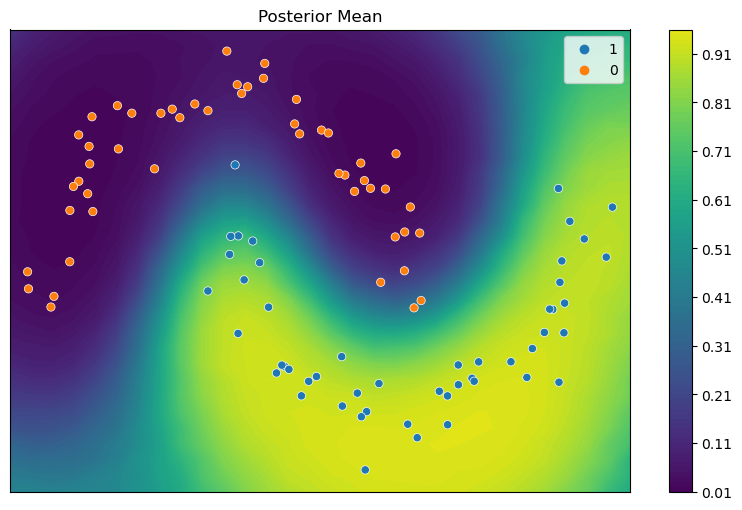

In [41]:
plot_pyro_predictions(posterior_samples=mcmc_samples, x=x, y=y) 

Plot the posterior predictive mean function over a finite grid of points, together with the training data. Comment on the results.

The classifier seems to be performing quite well, and is capable of determining the non-linear boundary which separates the two classes.
There is some chance that it would misclassify some of the at the "tip" of the two moons, but it correctly assigns probabilities.